# CP201A Lecture: Working with MOEs in the ACS
September 17, 2025

In this notebook, we're going to try and answer the question: which county in California has the highest percent of workers that are "supercommuters", meaning that they commute more than 60 minutes.  This is table B08303: Travel Time to Work: https://data.census.gov/table/ACSDT1Y2022.B08303


In [ ]:
!pip install census

In [ ]:
from census import Census
import pandas as pd
import numpy as np #This will be handy when we start doing math

## 1. Pulling and preparing data
We're going to start by pulling in some data - use your own Census API key.

In [ ]:
#Prepare Census Bureau API for data pulling
api_key = ''
c = Census(key=api_key)

In [ ]:
# Define the dictionary of variables to pull and rename
# I used the variables in the "group" table: https://api.census.gov/data/2023/acs/acs5/groups/B08303.html
variables_of_interest = {
    'NAME': 'NAME',  # no need to rename this variable
    'GEO_ID': 'GEO_ID',  # this one either
    'B08303_001E': 'tt_total',
    'B08303_001M': 'tt_total_moe',
    'B08303_012E': 'tt_60to89',
    'B08303_012M': 'tt_60to89_moe',
    'B08303_013E': 'tt_90plus',
    'B08303_013M': 'tt_90plus_moe',
}

In [ ]:
#Pull data using the Census Bureau API
df_county = pd.DataFrame(
    c.acs5.get(
        list(variables_of_interest.keys()),
        {'for': 'county:*', 'in': 'state:06'},
        year=2023
    )).rename(columns=variables_of_interest) #This is applying the rename function to the dataframe that's being created
#If we had only specified state:06, we would have gotten all the census tracts with those numbers across the state, 
#and if we would have only specified county:001, we would have gotten those census tracts for every county in the US with a 001 FIPS!

In [ ]:
df_county.head()

I can do a quick check to see if my data pulled correctly:
https://data.census.gov/table/ACSDT5Y2023.B08303?q=B08303:+Travel+Time+to+Work&g=040XX00US06$0500000


## 2. Aggregate estimates and MOEs

### 2.1 Combining categories (variables)
In this example, we're interested in calculating the share of workers in each county that travel more than 60 minutes to work.  We need to add the two estimates for 60 to 89 minutes, and over 90 minutes, and divide that by the total number of commuters. We then need to calculate the "derived" MOEs for both the count (number of workers who commute over 60 minutes) and the proportion (percent of workers who commute over 60 minutes.

In [ ]:
#create a new column that is the sum of 60 to 89 minutes and 90 plus, the total number of super commuters


In [ ]:
#create a new column that calculates the percent of super commuters

In [ ]:
#check to see if it worked!

### 2.2 Derived Count MOEs

To find the margin of error for a sum, we'll use this formula from the ACS Guide, page 59:

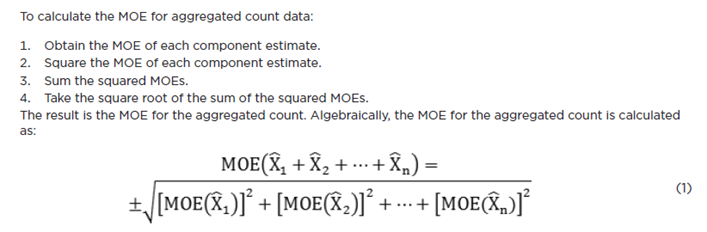

This formula is called a “root sum square” (RSS) and can also be simplified and written as:

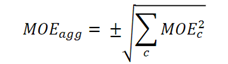

This may look complicated, but we can actually do it quickly and concisely with pandas! 

Let's break down the formula into a few steps. Then we'll see how to complete each step in Python, then put them all together into a one-line command.
1. Square the values in several columns.
2. Sum the squared values.
3. Take the square root of this sum.

We need to be able to square numbers and take the square root of numbers. We can do so with Python's built-in exponentiation operator `**`, or with some handy functions from `numpy`:

In [ ]:
# Let's review: two ways to square a number
print(5**2, np.square(5))

# Two ways to take the square root (sqrt is just raising a number to the 1/2 power)
print(5**0.5, np.sqrt(5))

In [ ]:
#first, let's see what happens if you just add the MOEs
df_county['tt_over60_moe_wrong'] = df_county['tt_60to89_moe'] + df_county['tt_90plus_moe'] 

In [ ]:
# Now, using the formula
df_county['tt_over60_moe_right'] = np.sqrt(df_county['tt_60to89_moe']**2 + df_county['tt_90plus_moe']**2)

# Let's compare; look at just the wrong and right columns 
df_county[["tt_over60_moe_wrong","tt_over60_moe_right"]].head(10)

In [ ]:
#here's a good chat gpt question - let's rename df_county['tt_over60_moe_right'] so it doesn't have the "right" in it


In [ ]:
#and let's drop df_county['tt_over60_moe_wrong']


## 2.3 Calculating derived proportions

The handbook writes out the formula this way (p. 64):

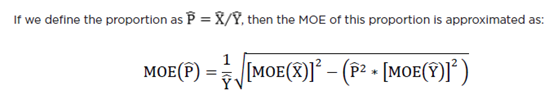

We define these variables as follows:
* $MOE(P)$ is the MOE of the derived proportion (what we are calculating!)
    * $P$ is the proportion we found by calculating $X$/$Y$
* $X$ is the estimate used as the numerator of the derived proportion
* $Y$ is the estimate used as the denominator of the derived proportion
* $MOE(X)$ is the MOE of the numerator
* $MOE(Y)$ is the MOE of the denominator

Let’s break down the formula.  What is your numerator? Denominator? Their MOEs? The proportion? 

In [ ]:
# As long as you don't mess with pandas indentation, you can use line breaks to make your code easier to read, 
# especially with big equations like this;  go ahead and see if you can do it!


In [ ]:
# You can export this DataFrame  to a csv file
# We specify index=False because our DF's index (the zeros on the left side) isn't meaningful
df_county.to_csv('traveltime_2023.csv', index=False)